In [24]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

def snr(data, z, k_s, k_e):
    """
    Calculate Signal-to-Noise Ratio (SNR) for features in specified range
    
    Parameters:
    data : ndarray of shape (n_samples, n_features)
        Input data matrix
    z : ndarray of shape (n_samples,)
        Group labels array for sample grouping
    k_s : int
        Start index of features (inclusive)
    k_e : int
        End index of features (exclusive)
    
    Returns:
    list_snr : list
        SNR values for features [k_s, k_e-1]
    """
    unique_values, indices = np.unique(z, return_inverse=True)
    dict_address = {val: np.where(indices == idx)[0] for idx, val in enumerate(unique_values)}
    list_snr=[]
    for i in range(k_s,k_e):
        var_E=[]
        E_var=[]
        d = data[:, i]
        for k,v in dict_address.items():
            a=d[v]
            E_a=np.mean(a)
            var_a=np.var(a)
            var_E.append(E_a)
            E_var.append(var_a)
        var_E=np.array(var_E)
        E_var=np.array(E_var)
        result=np.var(var_E)/np.mean(E_var)
        list_snr.append(result)
    return list_snr

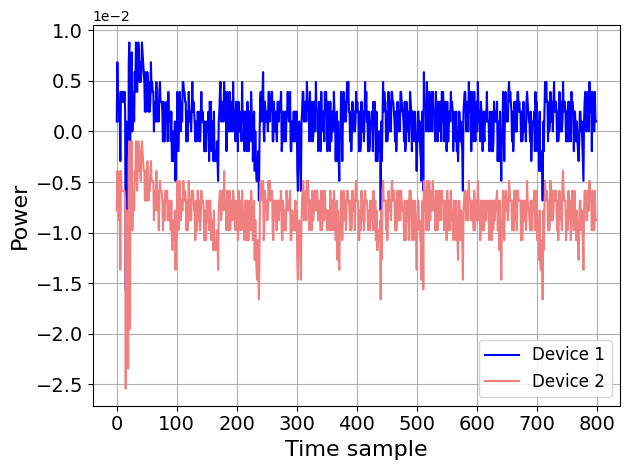

In [78]:

s = 0  # Start index
e = 800  # End index
x = np.arange(s, e)  # Generate x-axis values

# Plot device traces for comparison
plt.plot(x, traces_Source1[0, s:e], color='b', label='Device 1')
plt.plot(x, traces_Source2[0, s:e], color='lightcoral', label='Device 2')
plt.grid(True)  # Enable grid

plt.ylabel('Power', fontsize=16)  # Set y-axis label
plt.xlabel('Time sample', fontsize=16)  # Set x-axis label
plt.legend(fontsize=12)  # Display legend
plt.tick_params(labelsize=14)  # Set tick label size

# Set scientific notation on the y-axis with two decimal places
formatter = ScalarFormatter()
formatter.set_powerlimits((-2, 2))  # Control scientific notation display range
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()  # Adjust layout to prevent clipping

plt.savefig('trace_diff.pdf')
plt.show()  # Display the plot


<b>Muti-byte leakage analysis

In [14]:
nsamples=800
snr_AES_device1_MByte=[]
snr_AES_device2_MByte=[]
snr_SM4_device1_MByte=[]
snr_Skinny_device1_MByte=[]


AES_device1_path='../Dataset/AES_device1/'
AES_device2_path='../Dataset/AES_device2/'
SM4_device1_path='../Dataset/Skinny_device1/'
Skinny_device1_path='../Dataset/SM4_device1/'


for i in range(16):
    trace0=np.load(f'{AES_device1_path}trace_byte{i}.npy')
    label_V0=np.load(f'{AES_device1_path}label_V_byte{i}.npy')

    trace1=np.load(f'{AES_device2_path}trace_byte{i}.npy')
    label_V1=np.load(f'{AES_device2_path}label_V_byte{i}.npy')

    trace2=np.load(f'{SM4_device_path}trace_byte{i}.npy')
    label_V2=np.load(f'{SM4_device_path}label_V_byte{i}.npy')

    trace3=np.load(f'{Skinny_device1_path}trace_byte{i}.npy')
    label_V3=np.load(f'{Skinny_device1_path}label_V_byte{i}.npy')


    snr_AES_device1_MByte.append(snr(trace0,label_V0,0,nsamples))
    snr_AES_device2_MByte.append(snr(trace1,label_V1,0,nsamples))
    snr_SM4_device1_MByte.append(snr(trace2,label_V2,0,nsamples))
    snr_Skinny_device1_MByte.append(snr(trace3,label_V3,0,nsamples))

In [55]:
def calculate_snr_diff(snr_listA, snr_listB, POI_t):

    snr_diff = []
    # Calculate the coordinate differences on POI for snr_list
    for b in range(len(snr_listA)):  # Assume snr_listA and snr_listB have the same length
        # Calculate absolute differences at the specified POI
        diff = [abs(abs(snr_listA[b, i]) - abs(snr_listB[b, i])) for i in POI_t[b]]
        snr_diff.append(diff)
    snr_diff = np.array(snr_diff)

    # Calculate the average difference
    avg_diff = np.mean(snr_diff, axis=1)

    # Find the index of the maximum average difference
    max_index = np.argmax(avg_diff)

    return max_index, avg_diff


<b>Same device

In [71]:
# Using the original AES as the reference, find the 15 points with the highest SNR in each row
POI = [np.argsort(row)[-15:] for row in snr_AES_device1_MByte]  # Store indices of top 15 SNR points


In [72]:
max_index_SM4, avg_diff_SM4 = calculate_snr_diff(np.array(snr_AES_device1_MByte), np.array(snr_SM4_device1_MByte),POI)
max_index_SK, avg_diff_SK= calculate_snr_diff(np.array(snr_AES_device1_MByte), np.array(snr_Skinny_device1_MByte),POI)

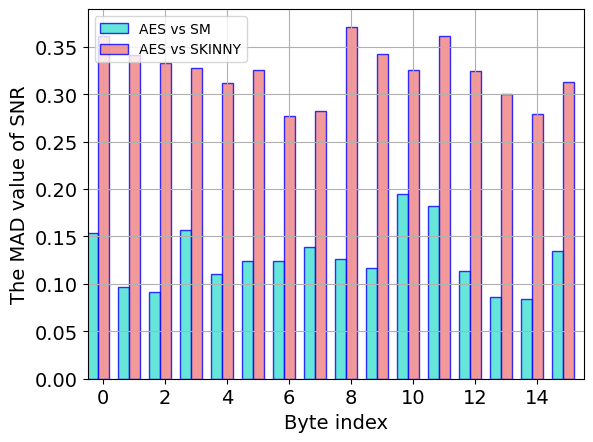

In [73]:
# Set the width of the bars
bar_width = 0.35  # Increase spacing, reduce width
index = np.arange(len(avg_diff_SM4))  # Generate index for x-axis

# Plot bar charts for AES vs SM and AES vs SKINNY
plt.bar(index - bar_width, avg_diff_SM4, bar_width, color='turquoise', label='AES vs SM', edgecolor='b', alpha=0.8)
plt.bar(index, avg_diff_SK, bar_width, color='lightcoral', label='AES vs SKINNY', edgecolor='b', alpha=0.8)

# Add labels and title
plt.xlabel('Byte index', fontsize=14)  # Set x-axis label
plt.ylabel('The MAD value of SNR', fontsize=14)  # Set y-axis label
plt.legend(fontsize=12)  # Display legend
plt.tick_params(labelsize=14)  # Set tick label size

# Set x-axis range to prevent bars from being cut off
plt.xlim(-0.5, len(avg_diff_SM4) - 0.5)

# Add legend and grid
plt.legend(loc='upper left')
plt.grid(True)


plt.savefig('MAD_sbox.pdf')
plt.show()


<b>Different device

In [74]:
max_index_SM4_CD, avg_diff_SM4_CD = calculate_snr_diff(np.array(snr_AES_device2_MByte), np.array(snr_SM4_device1_MByte),POI)
max_index_SK_CD, avg_diff_SK_CD= calculate_snr_diff(np.array(snr_AES_device2_MByte), np.array(snr_Skinny_device1_MByte),POI)
max_index_SK_AES_CD, avg_diff_AES_CD= calculate_snr_diff(np.array(snr_AES_device1_MByte), np.array(snr_AES_device2_MByte),POI)

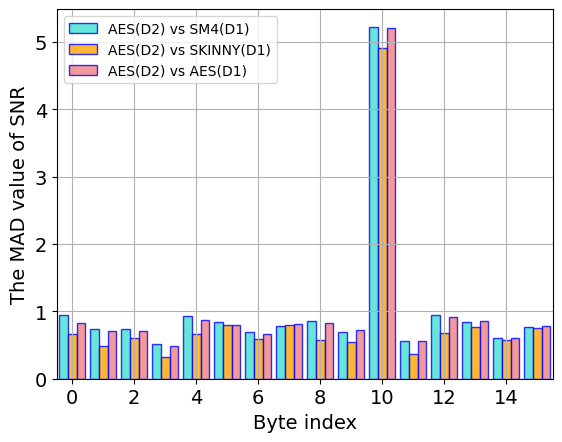

In [79]:

# Set the width of the bars
bar_width = 0.28  # Increase spacing, reduce width
index = np.arange(len(avg_diff_SM4))  # Generate index for x-axis

# Plot the first set of bars (AES vs SM4)
plt.bar(index - bar_width, avg_diff_SM4_CD, bar_width, color='turquoise', label='AES(D2) vs SM4(D1)', edgecolor='b', alpha=0.8)

# Plot the second set of bars (AES vs SKINNY)
plt.bar(index, avg_diff_SK_CD, bar_width, color='orange', label='AES(D2) vs SKINNY(D1)', edgecolor='b', alpha=0.8)

# Plot the third set of bars (AES vs AES)
plt.bar(index + bar_width, avg_diff_AES_CD, bar_width, color='lightcoral', label='AES(D2) vs AES(D1)', edgecolor='b', alpha=0.8)

# Add labels and title
plt.xlabel('Byte index', fontsize=14)  # Set x-axis label
plt.ylabel('The MAD value of SNR', fontsize=14)  # Set y-axis label
plt.legend(fontsize=12)  # Display legend
plt.tick_params(labelsize=14)  # Set tick label size

# Set x-axis range to prevent bars from being cut off
plt.xlim(-0.5, len(avg_diff_SM4) - 0.5)

# Add legend and grid
plt.legend()
plt.grid(True)

plt.savefig('MAD_copies.pdf')
plt.show()